# Bivariate Gaussian

## 6.a

In [15]:
mean = [0, 0]
cov = [[9, 0], [0, 1]]  

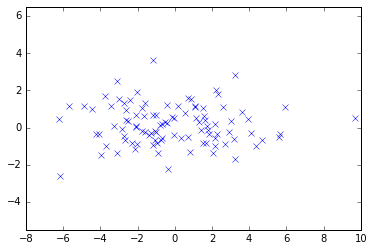

In [16]:
x, y = np.random.multivariate_normal(mean, cov, 100).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

## 6.b

In [17]:
mean = [0, 0]
cov = [[1, -.75], [-0.75, 1]]  

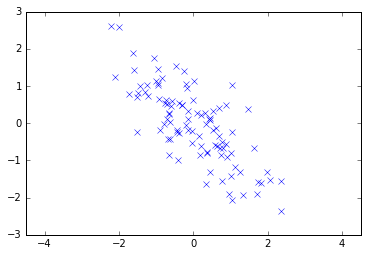

In [18]:
x, y = np.random.multivariate_normal(mean, cov, 100).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

# 9

## mnist Gaussian Classifier

In [162]:
import numpy as np
from sklearn.utils import check_X_y, check_array
from scipy.stats import multivariate_normal
import pandas as pd

### Load data

In [72]:
from struct import unpack
import numpy as np
import matplotlib.pylab as plt 
import sys
import os

def loadmnist(imagefile, labelfile):
    if os.path.isfile(imagefile+'.npy'):
        x = np.load(imagefile + '.npy')
        y = np.load(labelfile + '.npy')
        return (x,y)

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    
    np.save(imagefile + '.npy', x)
    np.save(labelfile + '.npy', y)
    
    return (x, y)

def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
#     plt.show()

In [5]:
X_train, Y_train = loadmnist('../gaussian_classifier/data/train-images-idx3-ubyte', 
'../gaussian_classifier/data/train-labels-idx1-ubyte')
X_test, Y_test = loadmnist('../gaussian_classifier/data/t10k-images-idx3-ubyte', 
'../gaussian_classifier/data/t10k-labels-idx1-ubyte')

In [10]:
print X_train.shape
print X_test.shape

(60000, 784)
(10000, 784)


## Implementation

Below is the model implementation

In [131]:
class GaussianClassifier(object):
    def __init__(self, c=1, cov_algo="numpy"):
        super(GaussianClassifier, self).__init__()
        self.c=c
        self.cov_algo = cov_algo

    def _examples_for_class(self, klass, X_train, Y_train):
        examples = []
        for i, example in enumerate(X_train):
            if Y_train[i]==klass:
                examples.append(example)
        
        examples = np.matrix(examples)
        return examples

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        print("c=%s, cov_algo=%s"%(self.c,self.cov_algo))
        
        classes=np.unique(y)
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        self.class_prior_ = np.zeros(n_classes)
        self.class_count_ = np.zeros(n_classes)
        unique_y = np.unique(y)
         
        for y_i in unique_y:
            i = classes.searchsorted(y_i)
            X_i = X[y == y_i, :]
            sw_i = None
            N_i = X_i.shape[0]
            
            self.class_count_[i] += N_i
        
        self.class_prior_[:] = self.class_count_ / np.sum(self.class_count_)
        self.priors = self.class_prior_
        
        self.posteriors=[]

        for klass in self.classes_:
            examples = self._examples_for_class(klass, X, y)
            mean = np.array(examples.mean(0))[0]
            cov = self._cov(examples)
            cov_smoothed = cov + (self.c * np.eye(mean.shape[0]))
            p_x = multivariate_normal(mean=mean, cov=cov_smoothed)
            self.posteriors.append(p_x)
        return self
    
    def predict(self, X):
        Y = []
        for x in X:
            bayes_probs = []
            for klass in self.classes_:
                prob = [klass, np.log(self.priors[klass]) + self.posteriors[klass].logpdf(x)]
                bayes_probs.append(prob)
            prediction = max(bayes_probs, key= lambda a: a[1])
            Y.append(prediction[0])
        return Y
        
    def _cov(self, examples):
        if self.cov_algo =="numpy":
            return np.cov(examples, rowvar=0)
        elif self.cov_algo == "EmpiricalCovariance":
            return EmpiricalCovariance().fit(examples).covariance_
        else:
            return None
            
    
    def get_params(self, deep=True):
        params = {'c': 1.0, 'cov_algo': 'numpy'}
        return params
    
    def set_params(self, **params):
        for key, value in params.iteritems():
            setattr(self, key, value)

### Fit the model

In [132]:
clf = GaussianClassifier()
clf.fit(X_train, Y_train)

c=1, cov_algo=numpy


### Determine the class probabilities

Below we output the baysian prior and posterior probabilities.

* `class_prior_` are the prior probabilities of the classes 0-9
* `posteriers` are the Gaussians for each class 0-9

Now, using bayes therom we an make predictions on test data.

In [18]:
clf.class_prior_

array([ 0.09871667,  0.11236667,  0.0993    ,  0.10218333,  0.09736667,
        0.09035   ,  0.09863333,  0.10441667,  0.09751667,  0.09915   ])

In [19]:
clf.posteriors

### Classify new digits

We will test all the digits in our test dataset and check the error rate

In [20]:
Y = clf.predict(X_test)

errors = (Y_test != Y).sum()
total = X_test.shape[0]
print("Success rate:\t %d/%d = %f" % ((total-errors,total,((total-errors)/float(total)))))
print("Error rate:\t %d/%d = %f" % ((errors,total,(errors/float(total)))))

Success rate:	 8412/10000 = 0.841200
Error rate:	 1588/10000 = 0.158800


Using our simple classifier (no paramerter tuning) we got a decent score of %84 

### Optimization

We can tune the parameters to get a better score.

#### Covariance Matrix smoothing

We can add a smoothing factor to our covariance matrix by tuing the `c` parameter of our model. Let's find the factor that get the highest accuracy. We know from experimentation that the best value is inbetween 3000 and 4000. Lets find a more exact value.

In [23]:
_c=[3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900]

for c in _c:
    clf =  GaussianClassifier(c=c)
    print "training..."
    clf.fit(X_train, Y_train)
    print "classifying..."
    Y = clf.predict(X_test)

    errors = (Y_test != Y).sum()
    total = X_test.shape[0]
    print("Success rate:\t %d/%d = %f" % ((total-errors,total,((total-errors)/float(total)))))

training...
c=3000, cov_algo=numpy
classifying...
Success rate:	 9565/10000 = 0.956500
training...
c=3100, cov_algo=numpy
classifying...
Success rate:	 9565/10000 = 0.956500
training...
c=3200, cov_algo=numpy
classifying...
Success rate:	 9564/10000 = 0.956400
training...
c=3300, cov_algo=numpy
classifying...
Success rate:	 9564/10000 = 0.956400
training...
c=3400, cov_algo=numpy
classifying...
Success rate:	 9565/10000 = 0.956500
training...
c=3500, cov_algo=numpy
classifying...
Success rate:	 9562/10000 = 0.956200
training...
c=3600, cov_algo=numpy
classifying...
Success rate:	 9564/10000 = 0.956400
training...
c=3700, cov_algo=numpy
classifying...
Success rate:	 9565/10000 = 0.956500
training...
c=3800, cov_algo=numpy
classifying...
Success rate:	 9566/10000 = 0.956600
training...
c=3900, cov_algo=numpy
classifying...
Success rate:	 9571/10000 = 0.957100


As you can see, c=`3400` looks like the optimum value:

In [24]:
clf =  GaussianClassifier(c=3400)
print "training..."
clf.fit(X_train, Y_train)
print "classifying..."
Y = clf.predict(X_test)

errors = (Y_test != Y).sum()
total = X_test.shape[0]
print("Success rate:\t %d/%d = %f" % ((total-errors,total,((total-errors)/float(total)))))
print("Error rate:\t %d/%d = %f" % ((errors,total,(errors/float(total)))))
print ""

training...
c=3400, cov_algo=numpy
classifying...
Success rate:	 9565/10000 = 0.956500
Error rate:	 435/10000 = 0.043500



As you can see we achieved an error rate of 4.3%

### Error Analysis

Let's take a look at some of the examples that were misclassified

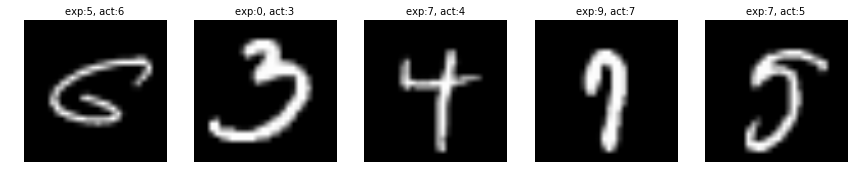

In [109]:
errors = Y_test != Y
indicies = np.array(np.where(errors==True))[0]
indicies = np.random.choice(indicies,5)


index = 0
rows = 1
cols = 10
plt.figure(figsize=(s,5))
for i in indicies:
    index += 1
    plt.subplot(rows, cols, index)
    displaychar(X_test[i])
    plt.title('exp:%i, act:%i' %( Y[i],Y_test[i]), fontsize = 10)

As you can see most of the errors the algorthm made are errors a human can make too 


Now we will show the posterior probabilities

In [166]:
err_classes = Y_test[indicies]
err_inputs = X_test[indicies]
print err_classes
priors = clf.priors

gaussians=np.array(clf.posteriors)

posts = []
for i,gaussian in enumerate(gaussians):
    for j, x in enumerate(err_inputs):
        post = gaussian.logpdf(x)
        posts.append(post)
pxs=np.array(posts)
pxs = pxs.reshape(10,5)
df = pd.DataFrame(pxs)
df.columns= err_classes
df

[6 3 4 7 5]


,6,3,4,7,5
0,-3075.946884,-3991.481861,-5836.290039,-6165.192444,-3320.723612
1,-74176.131827,-50241.758308,-11189.466481,-2855.363819,-7722.781325
2,-7008.235465,-2855.146616,-4577.553612,-4462.907203,-17125.505543
3,-32443.945013,-2779.749698,-3153.717663,-2821.573478,-2887.681289
4,-3418.608915,-64844.998752,-2570.321709,-2496.924101,-3130.056956
5,-3212.594253,-3646.063797,-3036.050087,-2862.564747,-2671.305656
6,-4774.960484,-134006.597711,-34876.551772,-46756.171635,-176336.423392
7,-3593.006669,-67518.667707,-2506.167334,-2445.818431,-2670.326600
8,-3605.872434,-19299.760123,-2662.155577,-2537.025966,-2575.895874
9,-3736.293361,-49475.363105,-2429.126298,-2271.933006,-2924.501713
